In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from shapely.geometry import Point

In [2]:
bmore = gpd.read_file('C:\\Users\\ochaudhary\\Downloads\\nhood_2010.shp')
bmore=bmore.to_crs({'init': 'epsg:4326'})

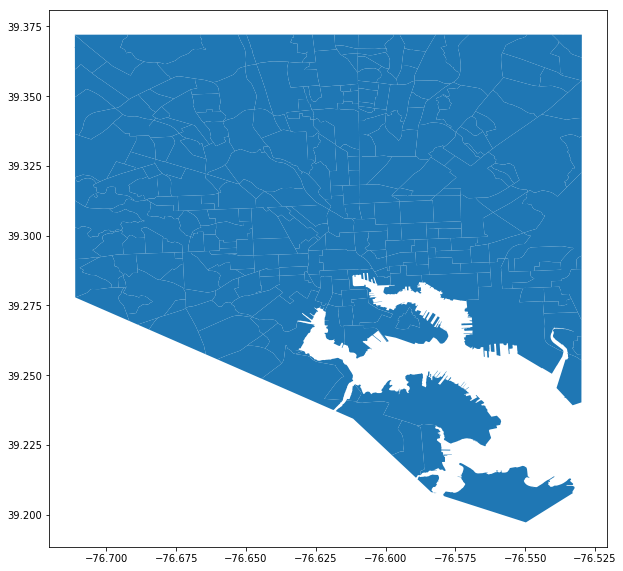

In [3]:
bmore.plot(figsize=(10,10))
plt.show()

In [10]:
crime = pd.read_csv('C:\\Users\\ochaudhary\\Downloads\\911_Police_Calls_for_Service.csv', nrows=100000)
#crime = pd.read_csv('C:\\Users\\ochaudhary\\Downloads\\911_Police_Calls_for_Service.csv')
crime.drop(['recordId', 'callDateTime', 'priority', 'district', 'callNumber', 'incidentLocation'], axis=1);

In [11]:
#regex on locations to actually look them up
#clustering alg on locations or just see what neighborhoods these calls are from
#regular expression for 
pattern = re.compile('\([0-9.-]+\,\s*[0-9.-]+\)')
pattern2 = re.compile('[0-9.-]+')

def clean(coords):
    return re.findall(pattern, coords)

def masker(coords):
    if len(re.findall(pattern,coords)) > 0:
        return True
    else:
        return False
    
def cleanlocs(colname):
    df = crime[crime.description == colname]
    df = df[['callDateTime' , 'location']]
    df=df.dropna(how='any')
    df.location = df.location.apply(lambda x: re.findall(pattern, x))
    df = df[df.location.apply(lambda x: True if len(x) > 0 else False)]
    df.location = df.location.apply(lambda x: x[0])
    df.location = df.location.apply(lambda x: re.findall(pattern2,x))
    df['lat']=df.location.apply(lambda x: float(x[0]))
    df['long']=df.location.apply(lambda x: float(x[1]))
    return df

def locstogdf(locs):
    geometry = [Point(xy) for xy in zip(locs.long, locs.lat)]
    locs = locs.drop(['long', 'lat'], axis=1)
    crs = {'init': 'epsg:4326'}
    return gpd.GeoDataFrame(locs, crs=crs, geometry=geometry)

def makemap(call_reason):
    reason_locs=cleanlocs(call_reason)
    reason_locs_gdf=locstogdf(reason_locs)
    reason_join=gpd.sjoin(bmore, reason_locs_gdf, how="inner", op='intersects')
    aggs_reason_locs=reason_join.dissolve(by='NBRDESC', aggfunc='count')
    return aggs_reason_locs.plot(column='index_right', figsize=(10,10),cmap='YlOrRd')

def makegdf(call_reason):
    reason_locs=cleanlocs(call_reason)
    reason_locs_gdf=locstogdf(reason_locs)
    reason_join=gpd.sjoin(bmore, reason_locs_gdf, how="inner", op='intersects')
    return reason_join.dissolve(by='NBRDESC', aggfunc='count')

In [6]:
assault_locs=makegdf('COMMON ASSAULT')

In [9]:
assault_locs.sort_values(by='location', ascending=False);

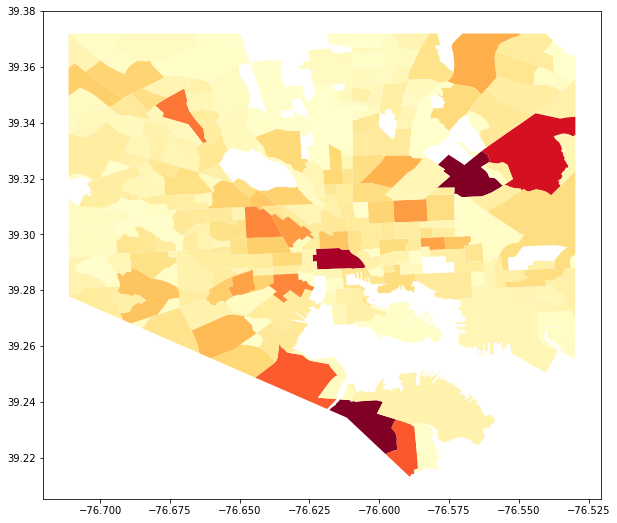

In [8]:
assault_locs.plot(column='index_right', figsize=(10,10),cmap='YlOrRd')

In [21]:
narc_locs=makegdf('NARCOTICSOutside')